In [1]:
NUM_SAMPLES = 1_000

In [2]:
from time import perf_counter

def build_execution_time(f):

    def execution_time(id_client: str) -> int:
        start = perf_counter()
        f(id_client)
        total_time = perf_counter() - start
        return int(total_time * 1_000)
    
    return execution_time

In [3]:
import requests

def build_rest_call(port: int):
    
    def rest_request(id_client: str):
        requests.get(f"http://127.0.0.1:{port}/predictions/{id_client}")

    return rest_request

rest_fastapi_time = build_execution_time(build_rest_call(3030))
rest_warp_time = build_execution_time(build_rest_call(3031))

In [4]:
import grpc
from predictions_pb2_grpc import PredictionsStub
from predictions_pb2 import PredictionRequest

def build_grpc_call(port: int):

    channel = grpc.insecure_channel(f"127.0.0.1:{port}")
    client = PredictionsStub(channel)

    def grpc_request(id_client: str) -> int:
        request = PredictionRequest(id_client=id_client)
        client.GetPredictions(request)
    
    return grpc_request

grpc_python_time = build_execution_time(build_grpc_call(50051))
grpc_golang_time = build_execution_time(build_grpc_call(50052))

In [5]:
import pandas as pd
predictions = pd.read_parquet('dataset-sample.parquet')

In [6]:
def get_response_time(f) -> list[int]:

    return [f(id_client)
            for id_client in 
            predictions['id_client'].sample(NUM_SAMPLES)]

In [7]:
rest_fastapi_timings = get_response_time(rest_fastapi_time)
rest_warp_timings = get_response_time(rest_warp_time)
grpc_python_timings = get_response_time(grpc_python_time)
grpc_golang_timings = get_response_time(grpc_golang_time)

df = pd.DataFrame({'rest (Python)': rest_fastapi_timings,
                   'rest (Rust)': rest_warp_timings,
                   'grpc (Python)': grpc_python_timings,
                   'grpc (Go)': grpc_golang_timings})

In [8]:
df.to_csv('timings_st.csv')

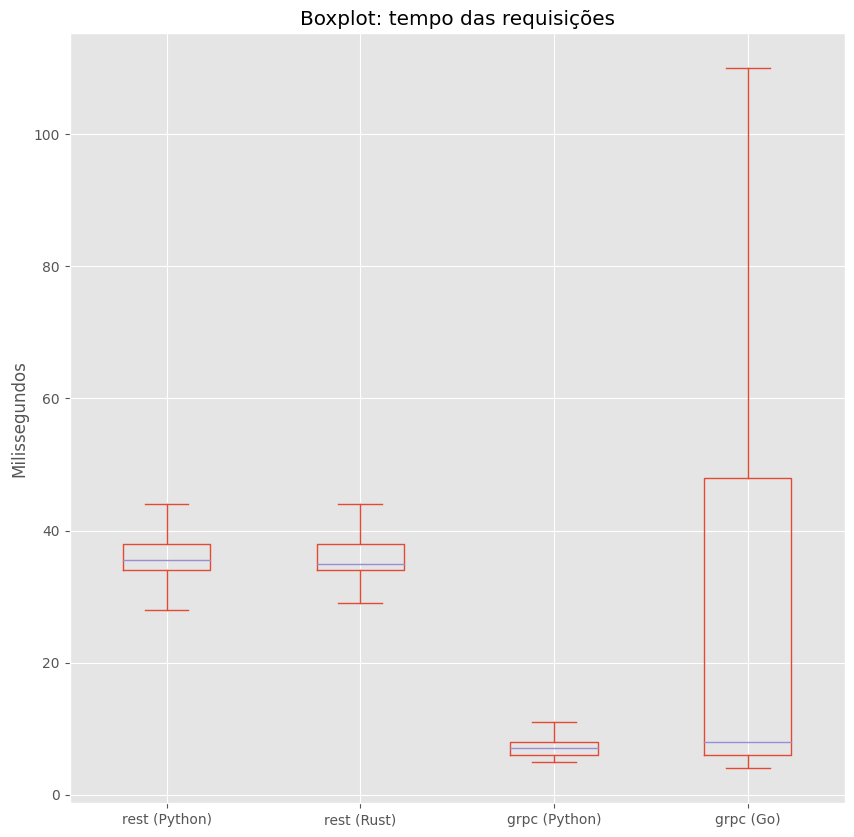

In [9]:
from matplotlib import style
from matplotlib import rcParams

rcParams['figure.figsize'] = 10,10
style.use('ggplot')

ax = df.plot.box(showfliers=False)
ax.set_title("Boxplot: tempo das requisições")
ax.set_ylabel("Milissegundos")

ax.figure.savefig('boxplot_no_outliers.svg',
                  bbox_inches='tight')

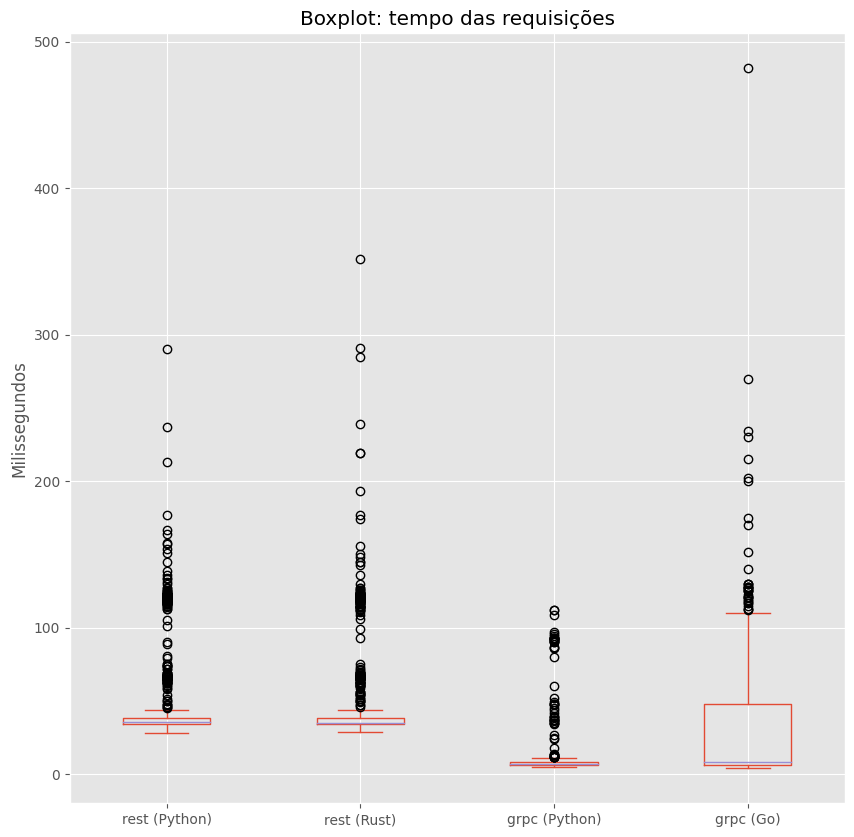

In [10]:
ax = df.plot.box()
ax.set_title("Boxplot: tempo das requisições")
ax.set_ylabel("Milissegundos")

ax.figure.savefig('boxplot_outliers.svg',
                  bbox_inches='tight')

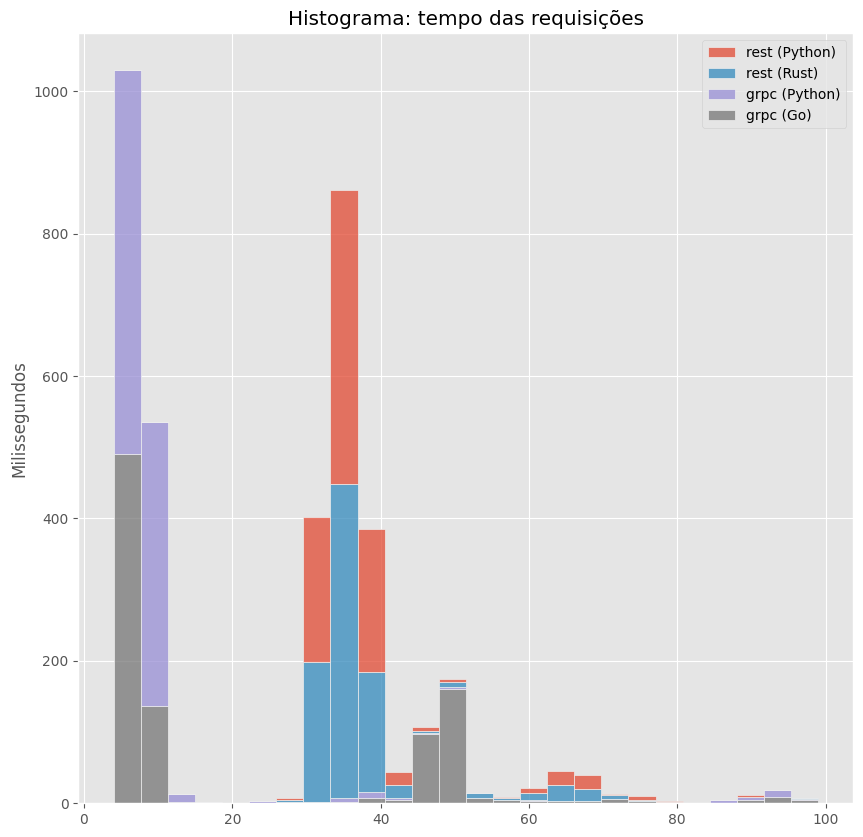

In [11]:
import seaborn as sns

ax = sns.histplot(df[df < 100], 
                  multiple="stack")

ax.set_title("Histograma: tempo das requisições")
ax.set_ylabel("Milissegundos")

ax.figure.savefig('histogram.svg',
                  bbox_inches='tight')

In [15]:
from typing import List
from concurrent.futures import ThreadPoolExecutor

def build_total_time(f):

    def execution_time(id_clients: List[str]) -> int:

        start = perf_counter()

        with ThreadPoolExecutor(max_workers=100) as executor:
            executor.map(f, id_clients)
        
        total_time = perf_counter() - start
        miliseconds = int(total_time * 1_000)
        print(f"Total time: {miliseconds}")

        return miliseconds
    

    return execution_time

def get_batch_time(batch_time,
                   num_batches = 20):

    print(f"Function: {batch_time}")

    samples = list(predictions['id_client']
                   .sample(NUM_SAMPLES))

    return [batch_time(samples)
            for _ in range(num_batches)]

In [16]:
rest_fastapi_timings = get_batch_time(build_total_time(build_rest_call(3030)))
rest_warp_timings = get_batch_time(build_total_time(build_rest_call(3031)))
grpc_python_timings = get_batch_time(build_total_time(build_grpc_call(50051)))
grpc_golang_timings = get_batch_time(build_total_time(build_grpc_call(50052)))

df = pd.DataFrame({'rest (Python)': rest_fastapi_timings,
                   'rest (Rust)': rest_warp_timings,
                   'grpc (Python)': grpc_python_timings,
                   'grpc (Go)': grpc_golang_timings})

Function: <function build_total_time.<locals>.execution_time at 0x157454540>
Total time: 1484
Total time: 1064
Total time: 1053
Total time: 1016
Total time: 1118
Total time: 836
Total time: 651
Total time: 638
Total time: 641
Total time: 679
Total time: 696
Total time: 657
Total time: 684
Total time: 697
Total time: 701
Total time: 647
Total time: 720
Total time: 712
Total time: 638
Total time: 687
Function: <function build_total_time.<locals>.execution_time at 0x157454540>
Total time: 637
Total time: 746
Total time: 720
Total time: 683
Total time: 693
Total time: 649
Total time: 684
Total time: 634
Total time: 662
Total time: 670
Total time: 685
Total time: 631
Total time: 677
Total time: 696
Total time: 634
Total time: 685
Total time: 616
Total time: 655
Total time: 673
Total time: 693
Function: <function build_total_time.<locals>.execution_time at 0x2b98e34c0>
Total time: 600
Total time: 439
Total time: 782
Total time: 450
Total time: 960
Total time: 505
Total time: 1058
Total time:

In [ ]:
df.to_csv('timings_mt.csv')

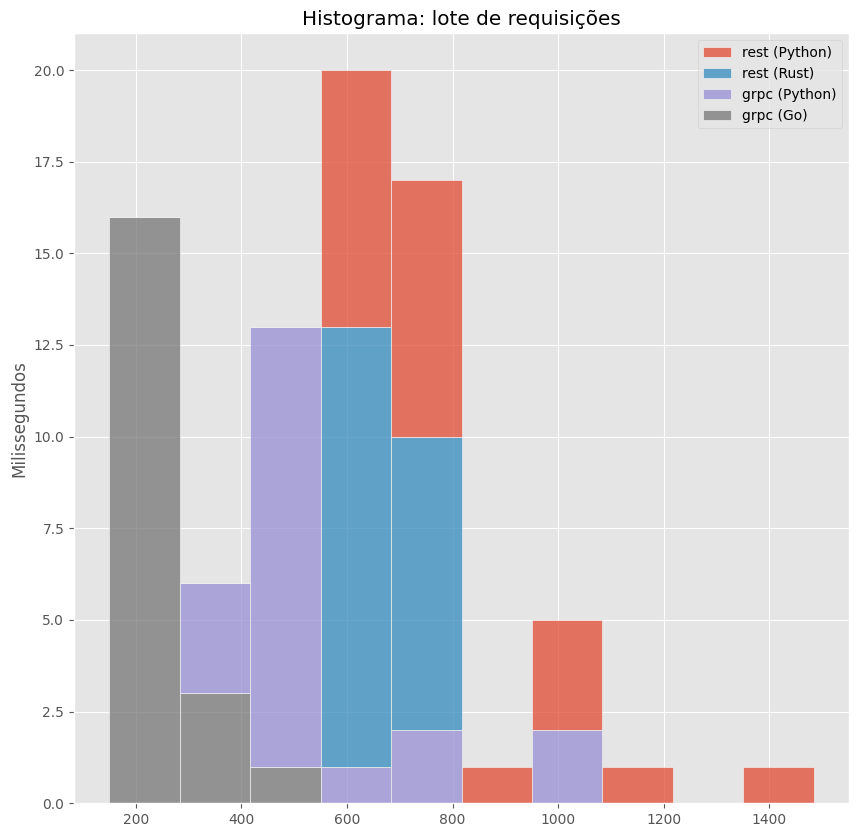

In [18]:
ax = sns.histplot(df, 
                  multiple="stack")

ax.set_title("Histograma: lote de requisições")
ax.set_ylabel("Milissegundos")

ax.figure.savefig('histogram_batch.svg',
                  bbox_inches='tight')